In [3]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('flights.csv') 
data, train_loader, val_loader, test_loader = get_data_loaders(data, 24, 10)
features = getFeatures()

<AxesSubplot: >

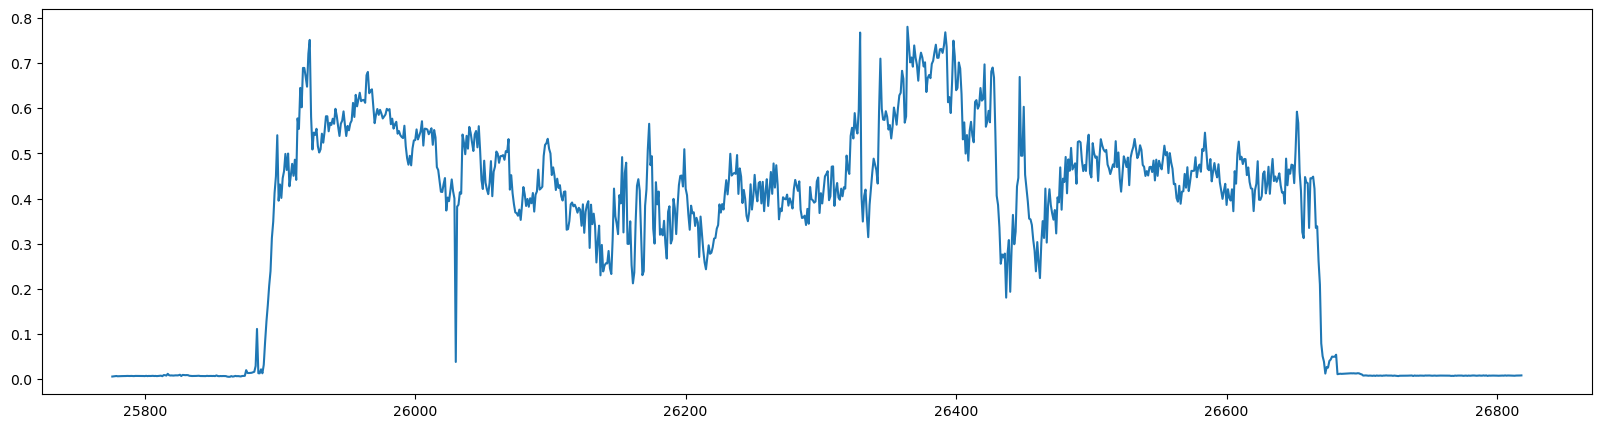

In [5]:
data[data['flight']==79]['power'].plot(figsize=(20, 5))

In [6]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 32])
torch.Size([64, 10])


In [7]:
# build TCN-LSTM model

class TCN(nn.Module):
    def __init__(self, input_size, input_len, output_size, output_len, tcn_num_channels, tcn_kernel_size=2, tcn_dropout=0.2):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_time = nn.Linear(input_len, output_len)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], output_size)
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = self.fc_time(output)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, output_size)

        return output


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(features)
output_size = 1
input_len = 24
output_len = 10
hidden_size = 32  

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
model = TCN(input_size, input_len, output_size, output_len, [64,64,64]).to(device)

cuda


In [12]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop with validation and early stopping
num_epochs = 36
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.4f}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(model.state_dict(), f'TCN_only_best_model_{input_len}-{output_len}.pt')


Epoch 1/36 [TRAIN]: 100%|██████████| 2418/2418 [00:39<00:00, 61.05it/s, train_loss=0.00334]


Epoch 1/36, Average Training Loss: 0.0028


Epoch 1/36 [VAL]: 100%|██████████| 806/806 [00:07<00:00, 114.35it/s, val_loss=0.00207]


Epoch 1/36, Average Validation Loss: 0.0026


Epoch 2/36 [TRAIN]: 100%|██████████| 2418/2418 [00:38<00:00, 62.88it/s, train_loss=0.00214]


Epoch 2/36, Average Training Loss: 0.0027


Epoch 2/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 131.09it/s, val_loss=0.00194]


Epoch 2/36, Average Validation Loss: 0.0025


Epoch 3/36 [TRAIN]: 100%|██████████| 2418/2418 [00:39<00:00, 60.48it/s, train_loss=0.002]  


Epoch 3/36, Average Training Loss: 0.0027


Epoch 3/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 129.81it/s, val_loss=0.00196]


Epoch 3/36, Average Validation Loss: 0.0026


Epoch 4/36 [TRAIN]: 100%|██████████| 2418/2418 [00:39<00:00, 60.67it/s, train_loss=0.0053] 


Epoch 4/36, Average Training Loss: 0.0026


Epoch 4/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 127.74it/s, val_loss=0.00246]


Epoch 4/36, Average Validation Loss: 0.0026


Epoch 5/36 [TRAIN]: 100%|██████████| 2418/2418 [00:40<00:00, 60.41it/s, train_loss=0.00139] 


Epoch 5/36, Average Training Loss: 0.0026


Epoch 5/36 [VAL]: 100%|██████████| 806/806 [00:07<00:00, 113.32it/s, val_loss=0.00189]


Epoch 5/36, Average Validation Loss: 0.0024


Epoch 6/36 [TRAIN]: 100%|██████████| 2418/2418 [00:41<00:00, 58.84it/s, train_loss=0.00223]


Epoch 6/36, Average Training Loss: 0.0025


Epoch 6/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 127.48it/s, val_loss=0.00215]


Epoch 6/36, Average Validation Loss: 0.0024


Epoch 7/36 [TRAIN]: 100%|██████████| 2418/2418 [00:41<00:00, 58.82it/s, train_loss=0.00213] 


Epoch 7/36, Average Training Loss: 0.0025


Epoch 7/36 [VAL]: 100%|██████████| 806/806 [00:07<00:00, 109.91it/s, val_loss=0.0018] 


Epoch 7/36, Average Validation Loss: 0.0024


Epoch 8/36 [TRAIN]: 100%|██████████| 2418/2418 [00:39<00:00, 60.64it/s, train_loss=0.00123] 


Epoch 8/36, Average Training Loss: 0.0025


Epoch 8/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 126.75it/s, val_loss=0.00193]


Epoch 8/36, Average Validation Loss: 0.0023


Epoch 9/36 [TRAIN]: 100%|██████████| 2418/2418 [00:40<00:00, 59.53it/s, train_loss=0.00187]


Epoch 9/36, Average Training Loss: 0.0025


Epoch 9/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 124.97it/s, val_loss=0.00191]


Epoch 9/36, Average Validation Loss: 0.0025


Epoch 10/36 [TRAIN]: 100%|██████████| 2418/2418 [00:39<00:00, 61.12it/s, train_loss=0.00136] 


Epoch 10/36, Average Training Loss: 0.0024


Epoch 10/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 125.40it/s, val_loss=0.00186]


Epoch 10/36, Average Validation Loss: 0.0023


Epoch 11/36 [TRAIN]: 100%|██████████| 2418/2418 [00:41<00:00, 58.22it/s, train_loss=0.00241]


Epoch 11/36, Average Training Loss: 0.0024


Epoch 11/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 131.43it/s, val_loss=0.00191]


Epoch 11/36, Average Validation Loss: 0.0024


Epoch 12/36 [TRAIN]: 100%|██████████| 2418/2418 [00:40<00:00, 59.90it/s, train_loss=0.00157]


Epoch 12/36, Average Training Loss: 0.0024


Epoch 12/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 127.53it/s, val_loss=0.00196]


Epoch 12/36, Average Validation Loss: 0.0025


Epoch 13/36 [TRAIN]: 100%|██████████| 2418/2418 [00:39<00:00, 61.38it/s, train_loss=0.00205]


Epoch 13/36, Average Training Loss: 0.0024


Epoch 13/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 125.63it/s, val_loss=0.00172]


Epoch 13/36, Average Validation Loss: 0.0023


Epoch 14/36 [TRAIN]: 100%|██████████| 2418/2418 [00:38<00:00, 62.33it/s, train_loss=0.00178]


Epoch 14/36, Average Training Loss: 0.0024


Epoch 14/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 124.52it/s, val_loss=0.00181]


Epoch 14/36, Average Validation Loss: 0.0023


Epoch 15/36 [TRAIN]: 100%|██████████| 2418/2418 [00:31<00:00, 76.10it/s, train_loss=0.00197] 


Epoch 15/36, Average Training Loss: 0.0024


Epoch 15/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 173.47it/s, val_loss=0.00169]


Epoch 15/36, Average Validation Loss: 0.0022


Epoch 16/36 [TRAIN]: 100%|██████████| 2418/2418 [00:31<00:00, 77.51it/s, train_loss=0.0027]  


Epoch 16/36, Average Training Loss: 0.0023


Epoch 16/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 128.52it/s, val_loss=0.00167]


Epoch 16/36, Average Validation Loss: 0.0023


Epoch 17/36 [TRAIN]: 100%|██████████| 2418/2418 [00:40<00:00, 59.89it/s, train_loss=0.00186]


Epoch 17/36, Average Training Loss: 0.0023


Epoch 17/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 123.72it/s, val_loss=0.00178]


Epoch 17/36, Average Validation Loss: 0.0023


Epoch 18/36 [TRAIN]: 100%|██████████| 2418/2418 [00:34<00:00, 70.09it/s, train_loss=0.00186] 


Epoch 18/36, Average Training Loss: 0.0023


Epoch 18/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 159.89it/s, val_loss=0.00179]


Epoch 18/36, Average Validation Loss: 0.0022


Epoch 19/36 [TRAIN]: 100%|██████████| 2418/2418 [00:30<00:00, 78.14it/s, train_loss=0.00262]


Epoch 19/36, Average Training Loss: 0.0023


Epoch 19/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 149.87it/s, val_loss=0.00171]


Epoch 19/36, Average Validation Loss: 0.0022


Epoch 20/36 [TRAIN]: 100%|██████████| 2418/2418 [00:36<00:00, 66.68it/s, train_loss=0.00171]


Epoch 20/36, Average Training Loss: 0.0023


Epoch 20/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 151.14it/s, val_loss=0.00158]


Epoch 20/36, Average Validation Loss: 0.0022


Epoch 21/36 [TRAIN]: 100%|██████████| 2418/2418 [00:37<00:00, 64.67it/s, train_loss=0.00246] 


Epoch 21/36, Average Training Loss: 0.0023


Epoch 21/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 142.22it/s, val_loss=0.00172]


Epoch 21/36, Average Validation Loss: 0.0022


Epoch 22/36 [TRAIN]: 100%|██████████| 2418/2418 [00:32<00:00, 75.22it/s, train_loss=0.00156]


Epoch 22/36, Average Training Loss: 0.0023


Epoch 22/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 156.86it/s, val_loss=0.00167]


Epoch 22/36, Average Validation Loss: 0.0022


Epoch 23/36 [TRAIN]: 100%|██████████| 2418/2418 [00:29<00:00, 81.77it/s, train_loss=0.00139]


Epoch 23/36, Average Training Loss: 0.0023


Epoch 23/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 177.23it/s, val_loss=0.0016] 


Epoch 23/36, Average Validation Loss: 0.0022


Epoch 24/36 [TRAIN]: 100%|██████████| 2418/2418 [00:32<00:00, 73.96it/s, train_loss=0.00152] 


Epoch 24/36, Average Training Loss: 0.0023


Epoch 24/36 [VAL]: 100%|██████████| 806/806 [00:06<00:00, 131.33it/s, val_loss=0.00174]


Epoch 24/36, Average Validation Loss: 0.0022


Epoch 25/36 [TRAIN]: 100%|██████████| 2418/2418 [00:39<00:00, 61.15it/s, train_loss=0.0021]  


Epoch 25/36, Average Training Loss: 0.0023


Epoch 25/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 141.74it/s, val_loss=0.00161]


Epoch 25/36, Average Validation Loss: 0.0021


Epoch 26/36 [TRAIN]: 100%|██████████| 2418/2418 [00:35<00:00, 69.03it/s, train_loss=0.00259]


Epoch 26/36, Average Training Loss: 0.0022


Epoch 26/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 186.60it/s, val_loss=0.00167]


Epoch 26/36, Average Validation Loss: 0.0022


Epoch 27/36 [TRAIN]: 100%|██████████| 2418/2418 [00:27<00:00, 86.56it/s, train_loss=0.00297]


Epoch 27/36, Average Training Loss: 0.0022


Epoch 27/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 186.22it/s, val_loss=0.00161]


Epoch 27/36, Average Validation Loss: 0.0021


Epoch 28/36 [TRAIN]: 100%|██████████| 2418/2418 [00:30<00:00, 79.24it/s, train_loss=0.00213] 


Epoch 28/36, Average Training Loss: 0.0022


Epoch 28/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 142.65it/s, val_loss=0.00167]


Epoch 28/36, Average Validation Loss: 0.0021


Epoch 29/36 [TRAIN]: 100%|██████████| 2418/2418 [00:38<00:00, 62.80it/s, train_loss=0.00228] 


Epoch 29/36, Average Training Loss: 0.0022


Epoch 29/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 139.41it/s, val_loss=0.00172]


Epoch 29/36, Average Validation Loss: 0.0021


Epoch 30/36 [TRAIN]: 100%|██████████| 2418/2418 [00:36<00:00, 65.85it/s, train_loss=0.00176] 


Epoch 30/36, Average Training Loss: 0.0022


Epoch 30/36 [VAL]: 100%|██████████| 806/806 [00:05<00:00, 146.10it/s, val_loss=0.00163]


Epoch 30/36, Average Validation Loss: 0.0021


Epoch 31/36 [TRAIN]: 100%|██████████| 2418/2418 [00:36<00:00, 66.95it/s, train_loss=0.00118]


Epoch 31/36, Average Training Loss: 0.0022


Epoch 31/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 164.94it/s, val_loss=0.00158]


Epoch 31/36, Average Validation Loss: 0.0021


Epoch 32/36 [TRAIN]: 100%|██████████| 2418/2418 [00:29<00:00, 82.52it/s, train_loss=0.0016]  


Epoch 32/36, Average Training Loss: 0.0022


Epoch 32/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 176.78it/s, val_loss=0.00164]


Epoch 32/36, Average Validation Loss: 0.0021


Epoch 33/36 [TRAIN]: 100%|██████████| 2418/2418 [00:27<00:00, 87.52it/s, train_loss=0.00212] 


Epoch 33/36, Average Training Loss: 0.0022


Epoch 33/36 [VAL]: 100%|██████████| 806/806 [00:03<00:00, 210.25it/s, val_loss=0.00166]


Epoch 33/36, Average Validation Loss: 0.0021


Epoch 34/36 [TRAIN]: 100%|██████████| 2418/2418 [00:26<00:00, 92.72it/s, train_loss=0.00182] 


Epoch 34/36, Average Training Loss: 0.0022


Epoch 34/36 [VAL]: 100%|██████████| 806/806 [00:03<00:00, 209.38it/s, val_loss=0.00288]


Epoch 34/36, Average Validation Loss: 0.0023


Epoch 35/36 [TRAIN]: 100%|██████████| 2418/2418 [00:28<00:00, 85.88it/s, train_loss=0.00176] 


Epoch 35/36, Average Training Loss: 0.0022


Epoch 35/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 190.73it/s, val_loss=0.00166]


Epoch 35/36, Average Validation Loss: 0.0021


Epoch 36/36 [TRAIN]: 100%|██████████| 2418/2418 [00:28<00:00, 83.99it/s, train_loss=0.00155] 


Epoch 36/36, Average Training Loss: 0.0022


Epoch 36/36 [VAL]: 100%|██████████| 806/806 [00:04<00:00, 195.12it/s, val_loss=0.00165]

Epoch 36/36, Average Validation Loss: 0.0022


Test loss: 0.003269076580181718
MAPE: 27.762340545654297


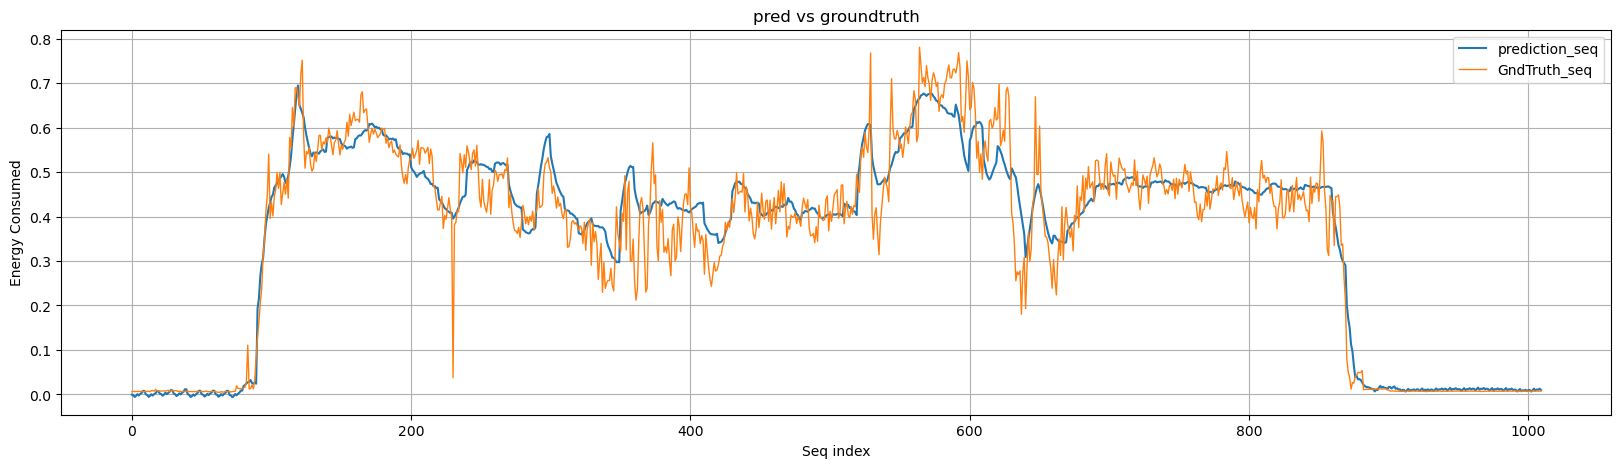

In [23]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
model.load_state_dict(torch.load('TCN_only_best_model_24-10.pt'))

# Test the model
model.eval()
flight_num = 79 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[features].values, 
                                         test_data['power'].values,24,10)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = model(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""

Model

In [ ]:
"""
TODO:

1. The TCN parameters of the orginal paper?

2. Model paramater tuning

"""
